In [1]:
import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image

import code

#import tensorflow.python.platform

import numpy
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models, datasets,regularizers
from helpers_images import * 

In [2]:
RATIO_VALIDATION = 0.1
NUMBER_TRAINING_EXAMPLES = 100
NUMBER_TEST_EXAMPLES = 50
SAVE_MODEL = False
LOAD_MODEL = False
DATA_LOADED = False

In [3]:
training_data_directory = "../data/training/"
test_data_directory = "../data/test_set_images/"
if not(DATA_LOADED):    
    train_data, train_labels = extract_train_data(NUMBER_TRAINING_EXAMPLES,True,True), extract_labels(training_data_directory, NUMBER_TRAINING_EXAMPLES,True,True)
    DATA_LOADED = True

print(train_data.shape)
print(train_labels.shape)

Loading ../data/training/images/satImage_001.png
Loading ../data/training/images/satImage_002.png
Loading ../data/training/images/satImage_003.png
Loading ../data/training/images/satImage_004.png
Loading ../data/training/images/satImage_005.png
Loading ../data/training/images/satImage_006.png
Loading ../data/training/images/satImage_007.png
Loading ../data/training/images/satImage_008.png
Loading ../data/training/images/satImage_009.png
Loading ../data/training/images/satImage_010.png
Loading ../data/training/images/satImage_011.png
Loading ../data/training/images/satImage_012.png
Loading ../data/training/images/satImage_013.png
Loading ../data/training/images/satImage_014.png
Loading ../data/training/images/satImage_015.png
Loading ../data/training/images/satImage_016.png
Loading ../data/training/images/satImage_017.png
Loading ../data/training/images/satImage_018.png
Loading ../data/training/images/satImage_019.png
Loading ../data/training/images/satImage_020.png
Loading ../data/trai

In [42]:
c0 = 0
c1 = 0
for label in train_labels:
    if label[0] == 1:
        c0 += 1
    else:
        c1+= 1
c0, c1        

(138926, 48574)

In [72]:
def build_model():
    model = keras.Sequential()
    #model.add(layers.RandomFlip("horizontal_and_vertical"))
    #model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomZoom(-0.3))
    model.add(layers.Conv2D(64, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.add(layers.Softmax())
    return model

In [73]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [74]:
model = build_model()
model.build(input_shape=(187500, 16, 16, 3))
model.summary()
model.compile(optimizer='adamax',
            loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=[f1_score, 'accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_4 (RandomZoom)  (187500, 16, 16, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (187500, 16, 16, 64)      256       
                                                                 
 max_pooling2d_16 (MaxPoolin  (187500, 8, 8, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (187500, 8, 8, 128)       8320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (187500, 4, 4, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (187500, 4, 4, 256)      

In [75]:
model.layers

In [45]:
epochs = 100
if not(LOAD_MODEL):
    history = model.fit(train_data, train_labels, epochs=epochs, validation_split = RATIO_VALIDATION)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5273/5274 [============================>.] - ETA: 0s - loss: 0.4723 - f1_score: 0.7726 - accuracy: 0.7726WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023F212559D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AU

In [12]:
import matplotlib.pyplot as plt
def plot(parameter_name, small_window = False):
    plt.plot(history.history[parameter_name], label=parameter_name)
    plt.plot(history.history['val_' + parameter_name], label = 'val_' + parameter_name)
    plt.xlabel('Epoch')
    plt.ylabel(parameter_name.capitalize())
    if small_window:
        plt.ylim([0.1, 0.7])
    else:
        plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [13]:
history.history.keys()

dict_keys(['loss', 'f1_score', 'accuracy', 'val_loss', 'val_f1_score', 'val_accuracy'])

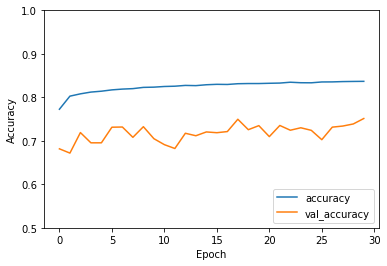

In [46]:
if not(LOAD_MODEL):
    plot('accuracy')

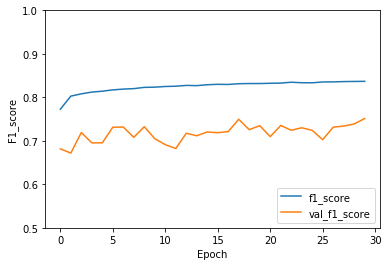

In [47]:
if not(LOAD_MODEL):
    plot('f1_score')

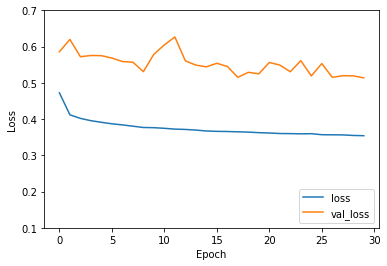

In [48]:
if not(LOAD_MODEL):
    plot('loss', True)

In [54]:
if LOAD_MODEL:
    loaded_model = tf.keras.models.load_model('model_seg.h5', custom_objects = {'f1_score': f1_score})
elif SAVE_MODEL:
    model.save("model_seg.h5")

In [55]:
if LOAD_MODEL:
    model = loaded_model

In [56]:
ex, label = train_data[0], train_labels[0]

In [57]:
train_data[0].shape

(16, 16, 3)

In [58]:
label

array([1., 0.], dtype=float32)

In [59]:
import pathlib

In [60]:
directory_path = pathlib.Path("../data/test_set_images/")

In [61]:
len(list(directory_path.glob('*/*.png')))

50

In [62]:
all_images = []
for i in range(1,51):
    image_in_directory = list(directory_path.glob("test_" + str(i) + "/*"))
    all_images.extend(image_in_directory)
img_height = img_width = 608

In [63]:
len(all_images)

50

In [64]:
all_images_arrays = []
for i in range(len(all_images)):
    img = tf.keras.utils.load_img(
        all_images[i], target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    all_images_arrays.append(img_array)
all_images_arrays = numpy.array(all_images_arrays)/255.0

In [65]:
all_images_arrays.max()

1.0

In [66]:
all_images_arrays.shape

(50, 608, 608, 3)

In [67]:
test_images = []
for i in range(len(all_images_arrays)):
    img_patched = extract_data_from_image(all_images_arrays[i])
    test_images.extend(img_patched)
test_images = numpy.array(test_images)

In [68]:
test_images.shape

(72200, 16, 16, 3)

In [69]:
predictions_testing = "predictions_testing/"
if not os.path.isdir(predictions_testing):
    os.mkdir(predictions_testing)

In [70]:
train_data[0].shape

(16, 16, 3)

In [71]:
stopper = input()
for i in range(len(all_images_arrays)):
    pimg,prediction = get_prediction_with_groundtruth(all_images_arrays[i], model)
    Image.fromarray(pimg[:,608:,:]).save(predictions_testing + "prediction_image_" + str(i+1) + ".png")
    Image.fromarray(pimg).save(predictions_testing + "prediction_" + str(i) + ".png")
    oimg = get_prediction_with_overlay(all_images_arrays[i], model)
    oimg.save(predictions_testing  + "overlay_" + str(i) + ".png")

 GO
